In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import csv
import json
import sklearn
from google.cloud import bigquery as bq
import seaborn as sns
import matplotlib.pyplot as plt
import time

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.options.mode.chained_assignment = None
%matplotlib inline

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, Normalizer, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error

In [3]:
# Set random seeds

sampling_seed = np.random.seed(13)
train_test_seed = np.random.seed(69)
cv_seed = np.random.seed(37)
model_seed = np.random.seed(73)
np.random.seed(42) # set default seed value

In [4]:
query="""
    SELECT
      *
    FROM
      `ual3d-277909.nl.zuid_holland_ml_df`
"""



In [5]:
full_df = bq.Client().query(query).to_dataframe()
full_df.head()

,osm_way_id,bldg_height,area,perimeter,length,building_levels,city,country,postcode,year,count_vertices,compactness,complexity,count_neighbor,state_name
0,731216391,0.16,44.479494,27.560880,10.049467,NaN,None,NL,None,2019.0,5,0.857811,10.672179,268.0,South Holland
1,264784178,2.76,4.621876,9.091209,3.397903,NaN,None,NL,None,1937.0,5,0.838286,6.200362,652.0,South Holland
2,267127254,10.02,81.670494,36.149066,12.806890,NaN,None,NL,None,1859.0,5,0.886218,12.024881,725.0,South Holland
3,290426964,2.52,8.079158,11.398810,4.065097,NaN,None,NL,None,1921.0,5,0.883952,6.761110,578.0,South Holland
4,274124231,10.24,59.357758,32.029666,11.757340,NaN,None,NL,None,1936.0,5,0.852690,11.539395,769.0,South Holland


In [50]:
ml_df = full_df.sample(frac=0.1, random_state=sampling_seed)
ml_df.head()

,osm_way_id,bldg_height,area,perimeter,length,building_levels,city,country,postcode,year,count_vertices,compactness,complexity,count_neighbor,state_name
1548257,274130582,9.18,51.265734,30.970887,11.720190,NaN,None,NL,None,2012.0,5,0.819530,11.574357,760.0,South Holland
394538,264830939,8.75,50.846286,29.376824,10.723068,NaN,None,NL,None,1955.0,7,0.860458,11.001199,805.0,South Holland
1091015,270160330,7.08,109.712479,43.872996,14.938549,NaN,None,NL,None,1987.0,9,0.846322,13.556054,31.0,South Holland
323112,272961023,9.73,58.685714,31.387989,11.236293,NaN,None,NL,None,1939.0,7,0.865182,11.340453,319.0,South Holland
930066,287746717,8.33,59.761344,37.267746,14.254992,NaN,None,NL,None,1980.0,7,0.735329,13.403803,630.0,South Holland


In [17]:
print(ml_df.shape)

(163867, 15)


In [18]:
print(ml_df.dtypes)

osm_way_id          object
bldg_height        float64
area               float64
perimeter          float64
length             float64
building_levels    float64
city                object
country             object
postcode            object
year               float64
count_vertices       int64
compactness        float64
complexity         float64
count_neighbor     float64
state_name          object
dtype: object


In [19]:
ml_df.set_index('osm_way_id', inplace=True)

ml_df["city"] = ml_df["city"].astype("category")
ml_df["postcode"] = ml_df["postcode"].astype("category")
ml_df["country"] = ml_df["country"].astype("category")
ml_df["state_name"] = ml_df["state_name"].astype("category")

ml_df.dtypes

bldg_height         float64
area                float64
perimeter           float64
length              float64
building_levels     float64
city               category
country            category
postcode           category
year                float64
count_vertices        int64
compactness         float64
complexity          float64
count_neighbor      float64
state_name         category
dtype: object

In [20]:
print('count unique city:', len(pd.unique(ml_df['city'])))
print('unique city:', pd.unique(ml_df['city']))

print('\ncount unique postcode:', len(pd.unique(ml_df['postcode'])))
print('unique postcode:', pd.unique(ml_df['postcode']))

print('\ncount unique year:', len(pd.unique(ml_df['year'])))
print('unique year:', pd.unique(ml_df['year']))

count unique city: 41
unique city: [NaN, Katwijk, Zoetermeer, Alblasserdam, 's-Gravenhage, ..., Pijnacker, Hazerswoude-Dorp, Zwijndrecht, Dirksland, Gouda]
Length: 41
Categories (40, object): [Katwijk, Zoetermeer, Alblasserdam, 's-Gravenhage, ..., Hazerswoude-Dorp, Zwijndrecht, Dirksland, Gouda]

count unique postcode: 79
unique postcode: [NaN, 2225BB, 2717AX, 2952BG, 2513AG, ..., 3247BN, 2514AP, 2719EL, 2803DT, 2513AX]
Length: 79
Categories (78, object): [2225BB, 2717AX, 2952BG, 2513AG, ..., 2514AP, 2719EL, 2803DT, 2513AX]

count unique year: 379
unique year: [1910. 2017. 1920. 1993. 1949. 2004. 1997. 1980. 2011. 1981. 2018. 1989.
 1933. 1959. 1957. 1973. 1990. 2006. 1979. 2002. 1987. 1927. 2014. 1962.
 1984. 1963. 1965. 1999. 1922. 1925. 1966. 1870. 1929. 1995. 1972. 2001.
 1971. 1938. 1930. 1903. 1998. 2010. 2007. 1985. 1952. 1936. 1939. 1950.
 1983. 1951. 2005. 1928. 1982. 1935. 1975. 1967. 2003. 1909. 1923. 1960.
 2000. 2009. 1954. 1850. 1996. 1953. 1986. 1977. 1908. 1974. 1900. 2

In [21]:
ml_df.isna().sum()


bldg_height             0
area                    0
perimeter               0
length                  0
building_levels    161651
city               163788
country                 0
postcode           163784
year                   15
count_vertices          0
compactness             0
complexity              0
count_neighbor         26
state_name              0
dtype: int64

In [22]:
label_col = ["bldg_height"]
# num_cols = ["area", "perimeter", "length", "building_levels", "year", "count_vertices", "compactness", "complexity", "count_neighbor"]
num_cols = ["area", "perimeter", "length", "building_levels", "year", "count_vertices", "compactness", "complexity", "count_neighbor"]
cat_cols = ["city", "postcode"]
# cat_cols = [col for col in df.columns if col not in (num_cols + label_col)]


In [23]:
cat_df_10prct = ml_df[cat_cols]
num_df_10prct = ml_df[num_cols]


In [24]:
num_df_10prct.describe()

,area,perimeter,length,building_levels,year,count_vertices,compactness,complexity,count_neighbor
count,163867.000000,163867.000000,163867.000000,2216.000000,163852.000000,163867.000000,163867.000000,163867.000000,163841.000000
mean,129.271734,34.511920,12.520065,1.507220,1970.061049,7.317166,0.820175,11.511445,626.342991
std,1138.092355,43.352369,15.185624,1.308745,37.224477,5.298142,0.070192,5.191303,307.905560
min,0.010735,0.414524,0.146975,-2.000000,1131.000000,4.000000,0.234890,1.287812,1.000000
25%,11.059746,13.820474,5.048321,1.000000,1957.000000,5.000000,0.791506,7.567110,428.000000
50%,50.056473,29.755423,10.850295,1.000000,1976.000000,5.000000,0.843854,11.133248,638.000000
75%,71.412326,38.869905,14.320070,2.000000,1994.000000,8.000000,0.871964,13.344857,832.000000
max,105192.634351,2073.894484,521.545921,15.000000,2020.000000,388.000000,0.999666,140.535339,2135.000000


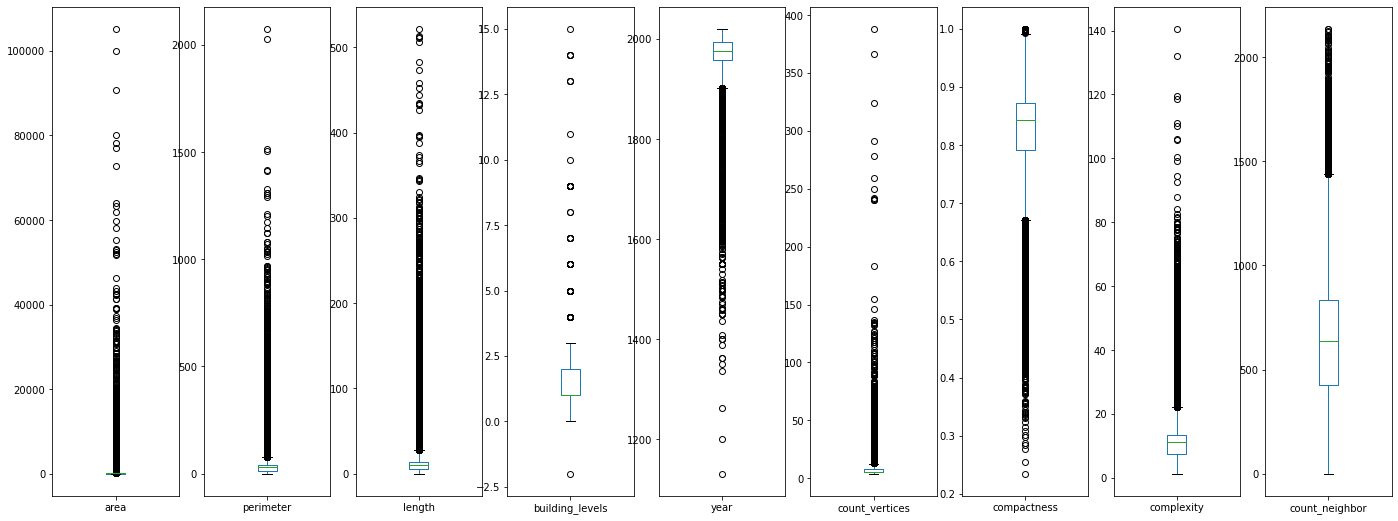

In [25]:

num_df_10prct.plot(kind='box', subplots=True, figsize=(24,9))
plt.plot()
plt.savefig('model_cv_10prct/run4/exploratory/south_holland_basic_distribution_null.png')

In [26]:
X = ml_df.drop('bldg_height', axis=1).drop(['country', 'state_name'], axis=1).drop(['perimeter'], axis=1)
y = ml_df['bldg_height']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=train_test_seed)

In [27]:
X.shape

(163867, 10)

In [28]:
y.shape

(163867,)

In [29]:
mean_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean', add_indicator=True)),
    ('normalizer', Normalizer())])

freq_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', add_indicator=True)),
    ('normalizer', Normalizer())])

zero_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=True)),
    ('normalizer', Normalizer())])

In [30]:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA', add_indicator=True)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [31]:
preprocessor = ColumnTransformer(transformers=[
        ('mean_transformer', mean_transformer, ["year"]),
        ('freq_transformer', freq_transformer, ["building_levels"]),
        ('zero_transformer', zero_transformer, ["count_neighbor"]),
        ('cat_transfomer', cat_transformer, cat_cols)])

In [32]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

In [33]:
print(sorted(sklearn.metrics.SCORERS.keys()) )

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted', 'v_measure_score']


In [34]:
regressors = []
regressors.append(('LR', LinearRegression()))
regressors.append(('DT', DecisionTreeRegressor(random_state=model_seed)))
# regressors.append(('DT', DecisionTreeRegressor(max_depth=30, random_state=42)))
regressors.append(('KNN', KNeighborsRegressor()))
# regressors.append(('KNN', KNeighborsRegressor(n_neighborsint=30, weights="distance")))
regressors.append(('RF', RandomForestRegressor(random_state=model_seed)))
# regressors.append(('RF', RandomForestRegressor(n_estimators=100, max_depth=10)))
regressors.append(('AB', AdaBoostRegressor(random_state=model_seed)))
regressors.append(('B', BaggingRegressor(random_state=model_seed)))
regressors.append(('GB', GradientBoostingRegressor(random_state=model_seed)))


In [35]:
mae_reg_scores = {}

In [36]:
for name, regressor in regressors:
    cv = ShuffleSplit(n_splits=5, test_size=.2, random_state=cv_seed)
    mdl_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])
    tic = time.process_time()
    scores = cross_val_score(mdl_pipeline, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error', error_score='raise', n_jobs=-1)
    toc = time.process_time()
    elapsed_time = toc - tic
    mae_reg_scores[name] = scores
    msg = "%s: avg: %f (std: %f, max: %f, min: %f) took %f seconds" % (name, scores.mean(), scores.std(), scores.max(), scores.min(), elapsed_time)
    print(msg)

LR: avg: -3.112621 (std: 0.008333, max: -3.102043, min: -3.124785) took 0.962961 seconds
DT: avg: -3.105148 (std: 0.008260, max: -3.090922, min: -3.113853) took 0.566798 seconds
KNN: avg: -3.305438 (std: 0.105162, max: -3.137773, min: -3.440709) took 0.562044 seconds
RF: avg: -3.100554 (std: 0.010985, max: -3.084555, min: -3.118470) took 0.547515 seconds
AB: avg: -3.112717 (std: 0.008556, max: -3.100466, min: -3.125503) took 0.570710 seconds
B: avg: -3.104668 (std: 0.012022, max: -3.084884, min: -3.121257) took 0.582850 seconds
GB: avg: -3.107527 (std: 0.008283, max: -3.096307, min: -3.117124) took 0.595537 seconds


In [37]:
mae_reg_scores

{'LR': array([-3.11956694, -3.10951923, -3.10718869, -3.12478488, -3.10204278]),
 'DT': array([-3.11282614, -3.09092171, -3.11385331, -3.10315605, -3.10498048]),
 'KNN': array([-3.44070865, -3.2458646 , -3.32788726, -3.37495557, -3.13777253]),
 'RF': array([-3.08455505, -3.09928859, -3.10373658, -3.0967193 , -3.11847027]),
 'AB': array([-3.10046551, -3.11451745, -3.1163714 , -3.12550262, -3.10673022]),
 'B': array([-3.08488382, -3.10689412, -3.11018344, -3.12125713, -3.10012154]),
 'GB': array([-3.09630703, -3.10227346, -3.117039  , -3.104891  , -3.11712416])}

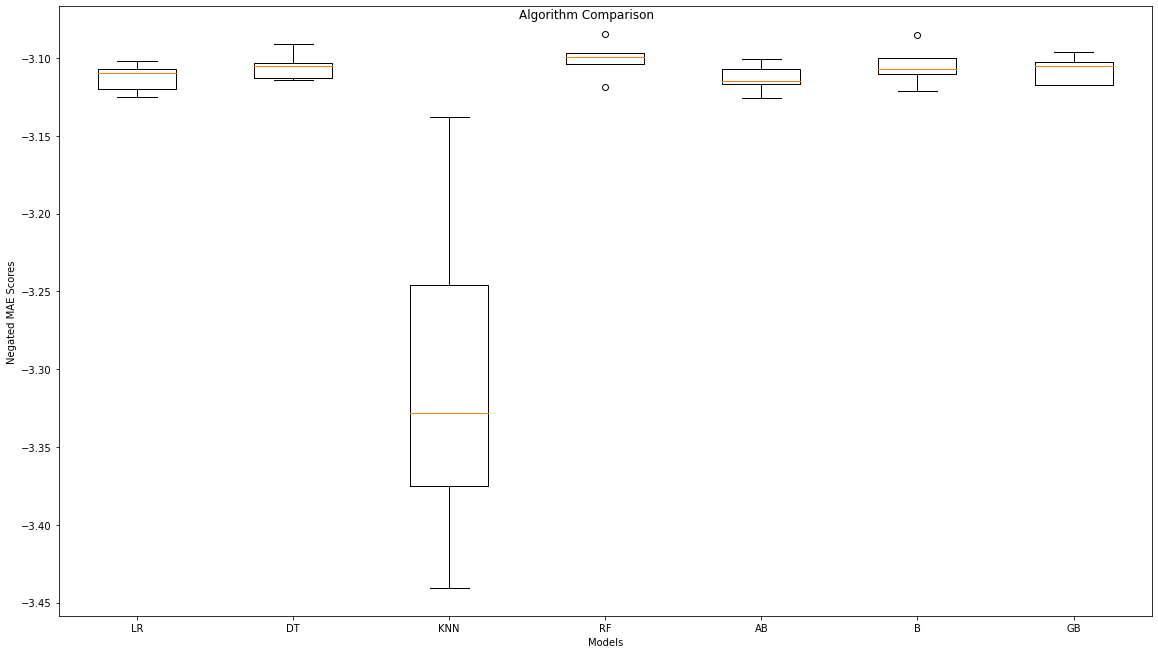

In [38]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot (111)

plt.boxplot(mae_reg_scores.values())
ax.set_xticklabels(mae_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Negated MAE Scores')
plt.savefig('model_cv_10prct/run4/normalizer/South-Holland-10prct_MAE.png', dpi=600)

In [39]:
abs_mae_reg_scores = {}
for k, v in mae_reg_scores.items():
    abs_mae_reg_scores[k] = np.absolute(v)

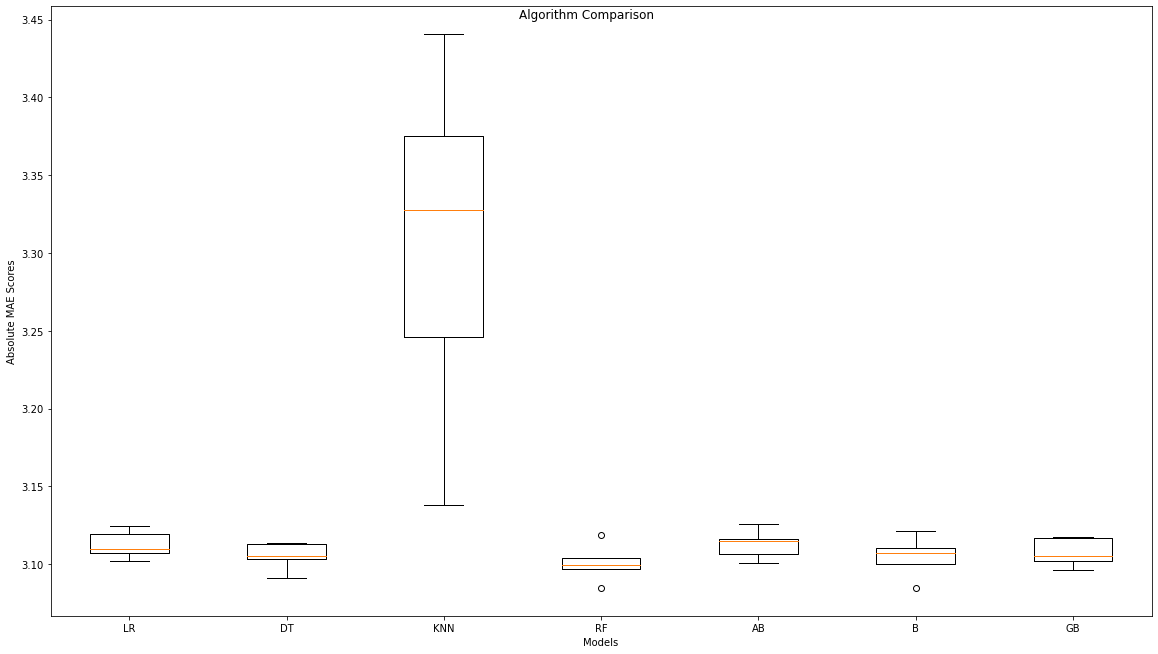

In [40]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot (111)


plt.boxplot(abs_mae_reg_scores.values())
ax.set_xticklabels(abs_mae_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Absolute MAE Scores')
plt.savefig('model_cv_10prct/run4/normalizer/South-Holland-10prct_ABS-MAE.png', dpi=600)

In [41]:

if 'KNN' in mae_reg_scores.keys():
    del mae_reg_scores['KNN'] 
mae_reg_scores

{'LR': array([-3.11956694, -3.10951923, -3.10718869, -3.12478488, -3.10204278]),
 'DT': array([-3.11282614, -3.09092171, -3.11385331, -3.10315605, -3.10498048]),
 'RF': array([-3.08455505, -3.09928859, -3.10373658, -3.0967193 , -3.11847027]),
 'AB': array([-3.10046551, -3.11451745, -3.1163714 , -3.12550262, -3.10673022]),
 'B': array([-3.08488382, -3.10689412, -3.11018344, -3.12125713, -3.10012154]),
 'GB': array([-3.09630703, -3.10227346, -3.117039  , -3.104891  , -3.11712416])}

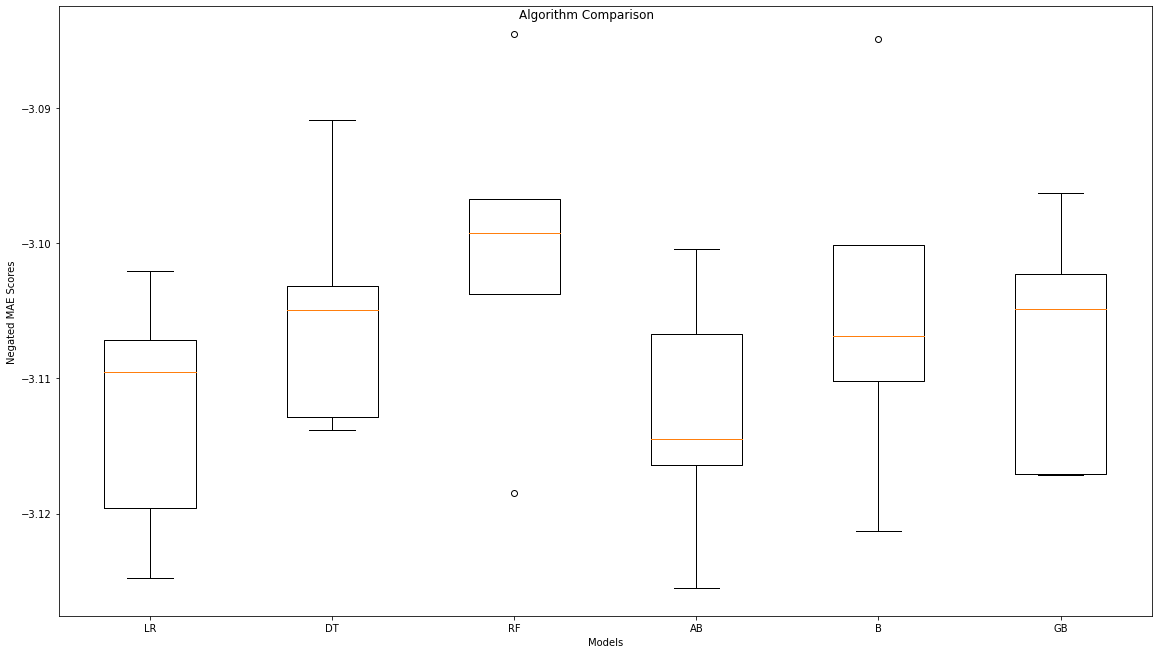

In [42]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(mae_reg_scores.values())
ax.set_xticklabels(mae_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Negated MAE Scores')
plt.savefig('model_cv_10prct/run4/normalizer/South-Holland-10prct_MAE_Except-KNN.png', dpi=600)


In [43]:
if 'KNN' in abs_mae_reg_scores.keys():
    del abs_mae_reg_scores['KNN'] 
abs_mae_reg_scores

{'LR': array([3.11956694, 3.10951923, 3.10718869, 3.12478488, 3.10204278]),
 'DT': array([3.11282614, 3.09092171, 3.11385331, 3.10315605, 3.10498048]),
 'RF': array([3.08455505, 3.09928859, 3.10373658, 3.0967193 , 3.11847027]),
 'AB': array([3.10046551, 3.11451745, 3.1163714 , 3.12550262, 3.10673022]),
 'B': array([3.08488382, 3.10689412, 3.11018344, 3.12125713, 3.10012154]),
 'GB': array([3.09630703, 3.10227346, 3.117039  , 3.104891  , 3.11712416])}

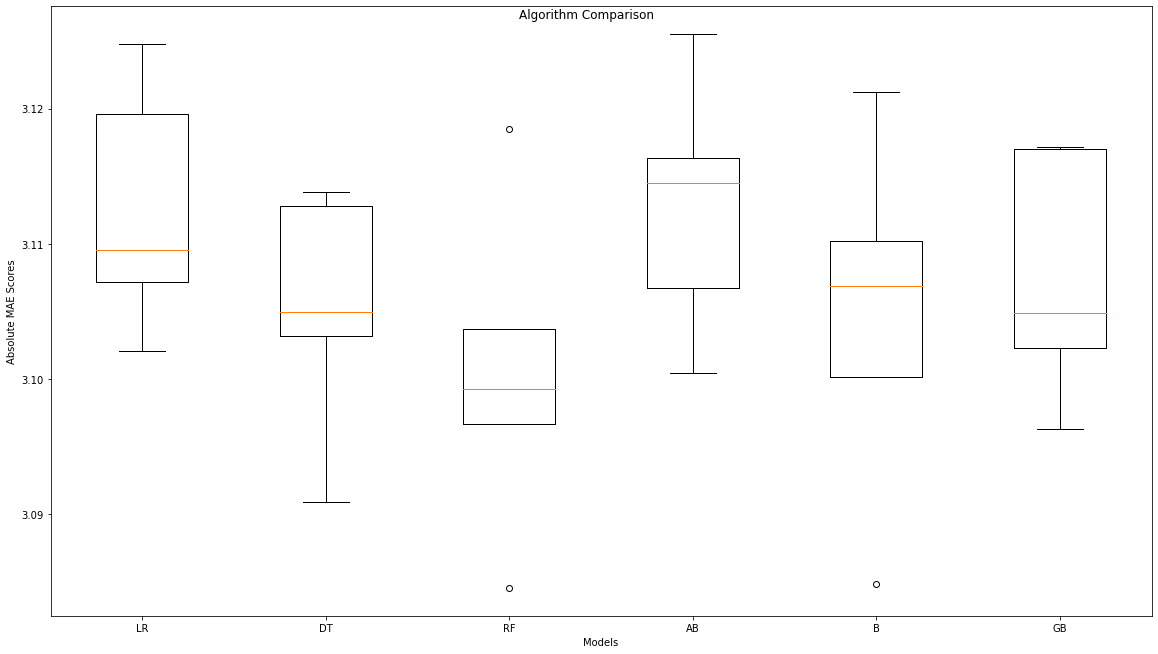

In [44]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(abs_mae_reg_scores.values())
ax.set_xticklabels(abs_mae_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Absolute MAE Scores')
plt.savefig('model_cv_10prct/run4/normalizer/South-Holland-10prct_ABS-MAE_Except-KNN.png', dpi=600)

In [45]:
mse_reg_scores = {}

In [46]:
for name, regressor in regressors:
    cv = ShuffleSplit(n_splits=5, test_size=.2, random_state=cv_seed)
    mdl_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])
    tic = time.process_time()
    scores = cross_val_score(mdl_pipeline, X_train, y_train, cv=cv, scoring='neg_mean_squared_error', error_score='raise', n_jobs=-1)
    toc = time.process_time()
    elapsed_time = toc - tic
    mse_reg_scores[name] = scores
    msg = "%s: avg: %f (std: %f, max: %f, min: %f) took %f seconds" % (name, scores.mean(), scores.std(), scores.max(), scores.min(), elapsed_time)
    print(msg)

LR: avg: -14.222599 (std: 0.279418, max: -13.719510, min: -14.477511) took 0.589597 seconds
DT: avg: -14.532792 (std: 0.344625, max: -14.039780, min: -14.986868) took 0.575773 seconds
KNN: avg: -16.107785 (std: 1.850810, max: -14.165079, min: -19.487787) took 0.588954 seconds
RF: avg: -13.935660 (std: 0.377732, max: -13.289442, min: -14.441708) took 0.772813 seconds
AB: avg: -14.190682 (std: 0.283566, max: -13.835061, min: -14.573188) took 0.574966 seconds
B: avg: -14.542017 (std: 0.526855, max: -13.952117, min: -15.199573) took 0.585112 seconds
GB: avg: -14.286099 (std: 0.333767, max: -13.781434, min: -14.645844) took 0.557456 seconds


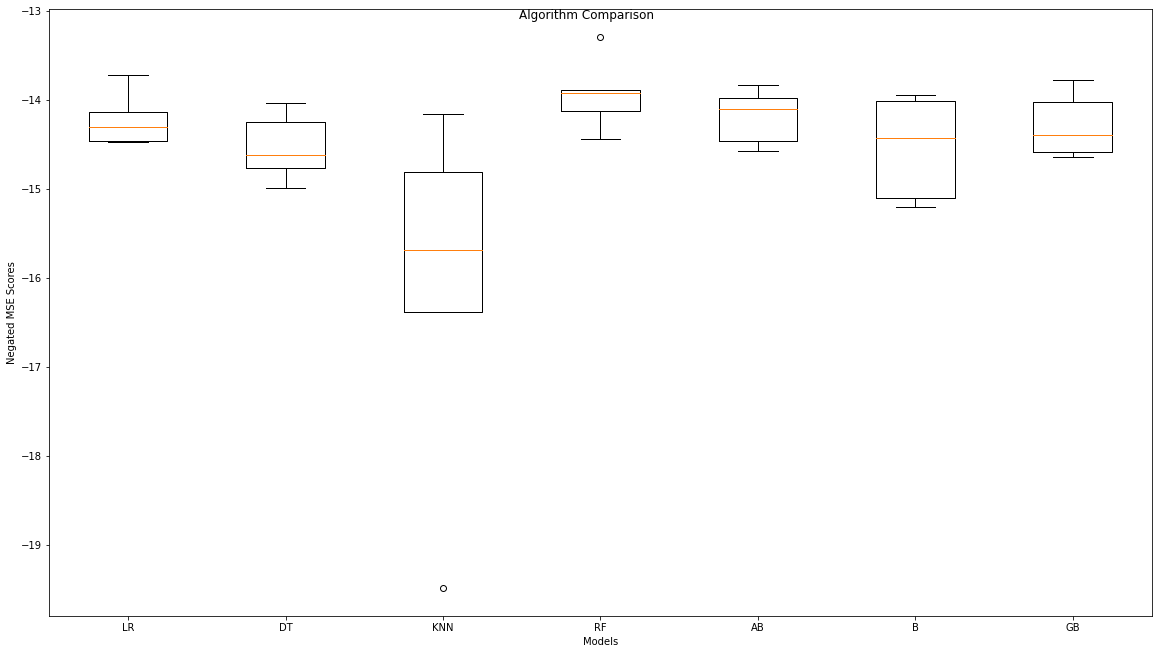

In [47]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(mse_reg_scores.values())
ax.set_xticklabels(mse_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Negated MSE Scores')
plt.savefig('model_cv_10prct/run4/normalizer/South-Holland-10prct_MSE.png', dpi=600)
plt.show()

In [48]:
abs_mse_reg_scores = {}
for k, v in mse_reg_scores.items():
    abs_mse_reg_scores[k] = np.absolute(v)
    
abs_mse_reg_scores

{'LR': array([14.14276168, 14.30875326, 14.47751088, 14.46445816, 13.71951031]),
 'DT': array([14.77030825, 14.9868677 , 14.0397797 , 14.24849447, 14.61850938]),
 'KNN': array([16.38778148, 15.68274273, 14.16507941, 14.81553216, 19.48778679]),
 'RF': array([13.92454265, 13.89265198, 14.44170811, 14.12995647, 13.28944159]),
 'AB': array([13.8350605 , 13.97819748, 14.10059184, 14.46637051, 14.57318795]),
 'B': array([15.19957348, 14.01800013, 15.10842287, 14.43196975, 13.95211747]),
 'GB': array([14.587514  , 14.39466696, 14.02103364, 13.7814342 , 14.6458439 ])}

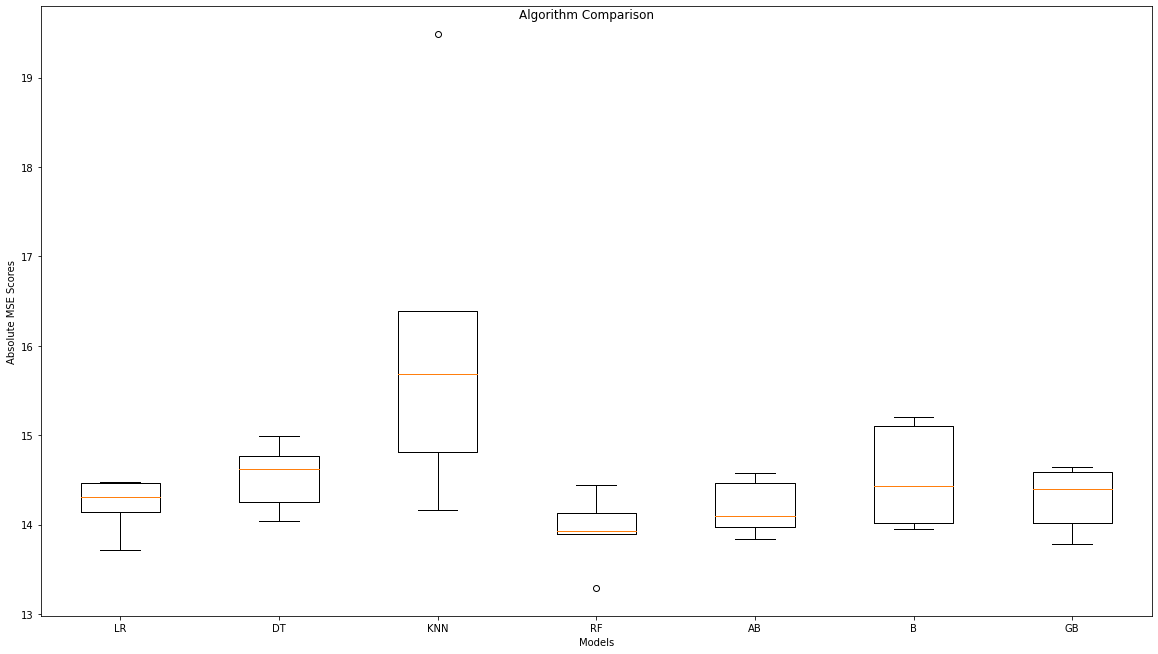

In [49]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot (111)


plt.boxplot(abs_mse_reg_scores.values())
ax.set_xticklabels(abs_mse_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Absolute MSE Scores')
plt.savefig('model_cv_10prct/run4/normalizer/South-Holland-10prct_ABS-MSE.png', dpi=600)

In [51]:
if 'KNN' in mse_reg_scores.keys():
    del mse_reg_scores['KNN'] 
mse_reg_scores

{'LR': array([-14.14276168, -14.30875326, -14.47751088, -14.46445816,
        -13.71951031]),
 'DT': array([-14.77030825, -14.9868677 , -14.0397797 , -14.24849447,
        -14.61850938]),
 'RF': array([-13.92454265, -13.89265198, -14.44170811, -14.12995647,
        -13.28944159]),
 'AB': array([-13.8350605 , -13.97819748, -14.10059184, -14.46637051,
        -14.57318795]),
 'B': array([-15.19957348, -14.01800013, -15.10842287, -14.43196975,
        -13.95211747]),
 'GB': array([-14.587514  , -14.39466696, -14.02103364, -13.7814342 ,
        -14.6458439 ])}

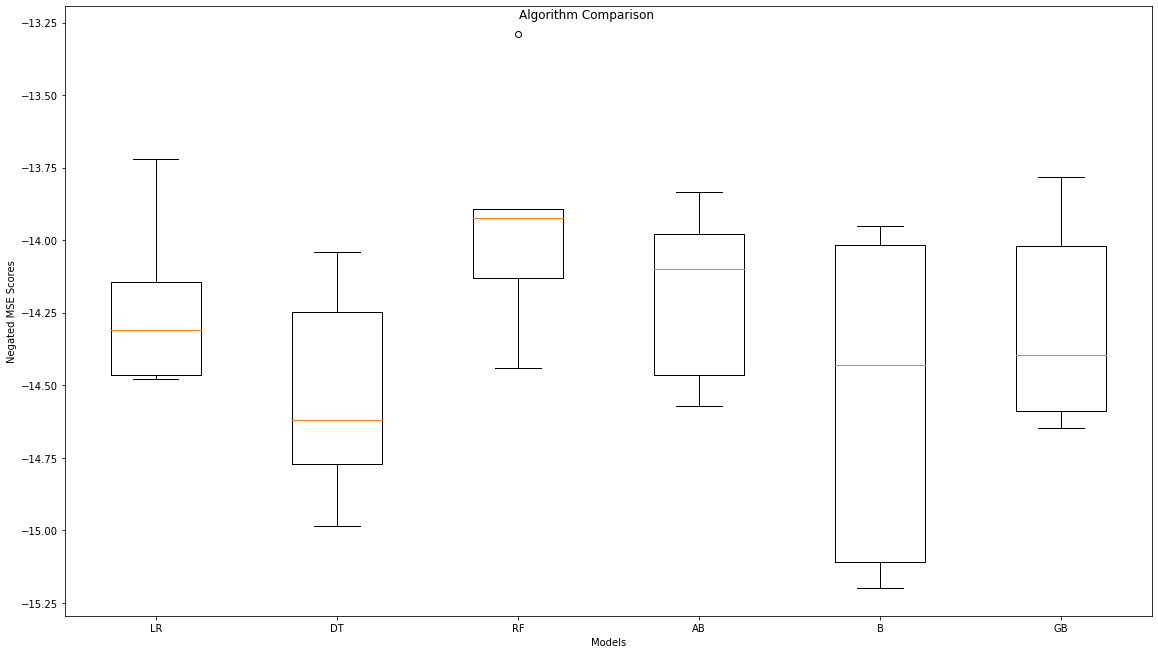

In [52]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(mse_reg_scores.values())
ax.set_xticklabels(mse_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Negated MSE Scores')
plt.savefig('model_cv_10prct/run4/normalizer/South-Holland-10prct_MSE_Except-KNN.png', dpi=600)
plt.show()

In [53]:
if 'KNN' in abs_mse_reg_scores.keys():
    del abs_mse_reg_scores['KNN'] 
abs_mse_reg_scores

{'LR': array([14.14276168, 14.30875326, 14.47751088, 14.46445816, 13.71951031]),
 'DT': array([14.77030825, 14.9868677 , 14.0397797 , 14.24849447, 14.61850938]),
 'RF': array([13.92454265, 13.89265198, 14.44170811, 14.12995647, 13.28944159]),
 'AB': array([13.8350605 , 13.97819748, 14.10059184, 14.46637051, 14.57318795]),
 'B': array([15.19957348, 14.01800013, 15.10842287, 14.43196975, 13.95211747]),
 'GB': array([14.587514  , 14.39466696, 14.02103364, 13.7814342 , 14.6458439 ])}

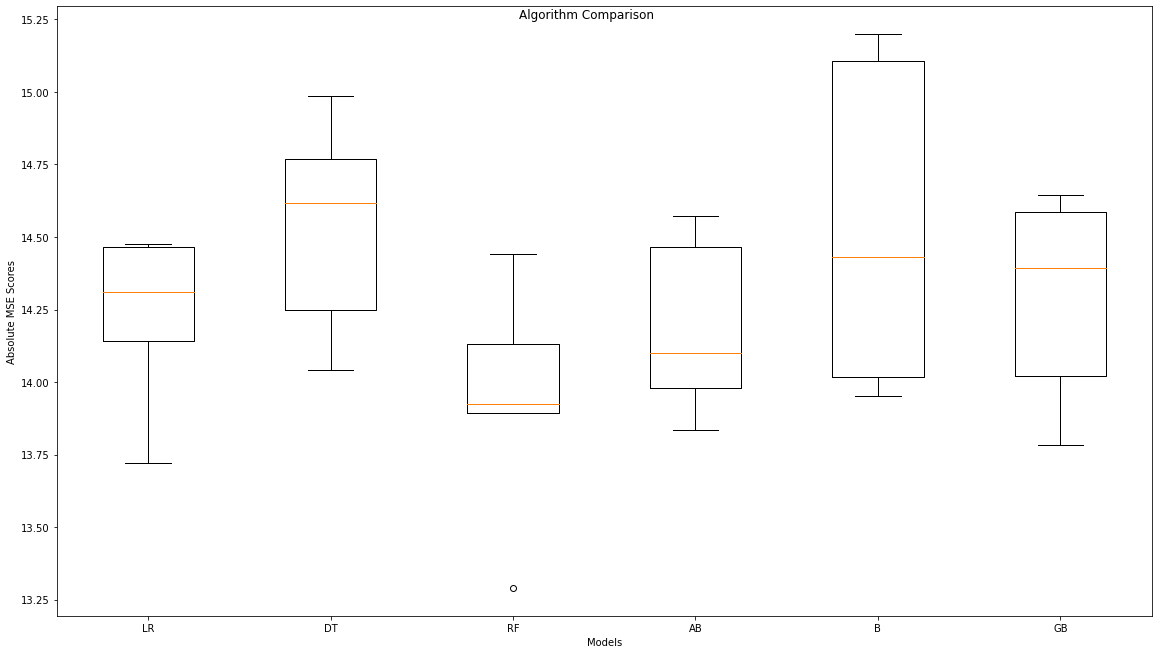

In [54]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(abs_mse_reg_scores.values())
ax.set_xticklabels(abs_mse_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Absolute MSE Scores')
plt.savefig('model_cv_10prct/run4/normalizer/South-Holland-10prct_ABS-MSE_Except-KNN.png', dpi=600)
plt.show()

In [55]:
r2_reg_scores = {}

In [56]:
for name, regressor in regressors:
    cv = ShuffleSplit(n_splits=5, test_size=.2, random_state=cv_seed)
    mdl_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])
    tic = time.process_time()
    scores = cross_val_score(mdl_pipeline, X_train, y_train, cv=cv, scoring='r2', error_score='raise', n_jobs=-1)
    toc = time.process_time()
    elapsed_time = toc - tic
    r2_reg_scores[name] = scores
    msg = "%s: avg: %f (std: %f, max: %f, min: %f) took %f seconds" % (name, scores.mean(), scores.std(), scores.max(), scores.min(), elapsed_time)
    print(msg)

LR: avg: 0.001518 (std: 0.000994, max: 0.002685, min: -0.000002) took 0.596710 seconds
DT: avg: 0.000343 (std: 0.001257, max: 0.002396, min: -0.001570) took 0.569301 seconds
KNN: avg: -0.214838 (std: 0.294432, max: -0.008479, min: -0.790633) took 0.588901 seconds
RF: avg: 0.001734 (std: 0.000583, max: 0.002736, min: 0.001134) took 0.779898 seconds
AB: avg: -0.003993 (std: 0.004562, max: 0.000283, min: -0.012175) took 0.586288 seconds
B: avg: 0.001369 (std: 0.000647, max: 0.002272, min: 0.000607) took 0.574222 seconds
GB: avg: 0.001319 (std: 0.000784, max: 0.002650, min: 0.000468) took 0.552526 seconds


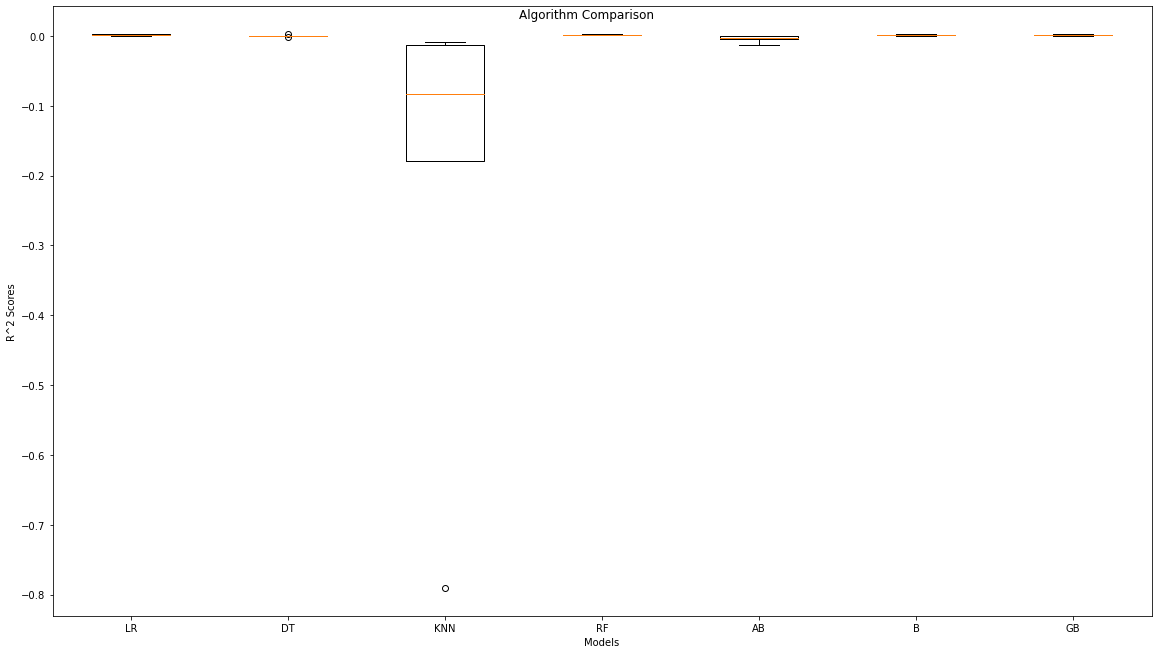

In [57]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(r2_reg_scores.values())
ax.set_xticklabels(r2_reg_scores.keys())


plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('R^2 Scores')
plt.savefig('model_cv_10prct/run4/normalizer/South-Holland-10prct_R2.png', dpi=600)
plt.show()

In [58]:
if 'KNN' in r2_reg_scores.keys():
    del r2_reg_scores['KNN']
r2_reg_scores

{'LR': array([ 1.80394640e-03, -1.73948178e-06,  2.31928995e-03,  7.83268084e-04,
         2.68545566e-03]),
 'DT': array([ 0.00028342, -0.00157015,  0.00038764,  0.00239609,  0.00022018]),
 'RF': array([0.00273578, 0.00203204, 0.00143107, 0.00133933, 0.00113388]),
 'AB': array([-0.00323808,  0.0001602 , -0.00499701,  0.00028337, -0.01217477]),
 'B': array([0.00195159, 0.00122297, 0.00227195, 0.00060743, 0.0007908 ]),
 'GB': array([0.00265012, 0.00046788, 0.00076934, 0.00098231, 0.00172552])}

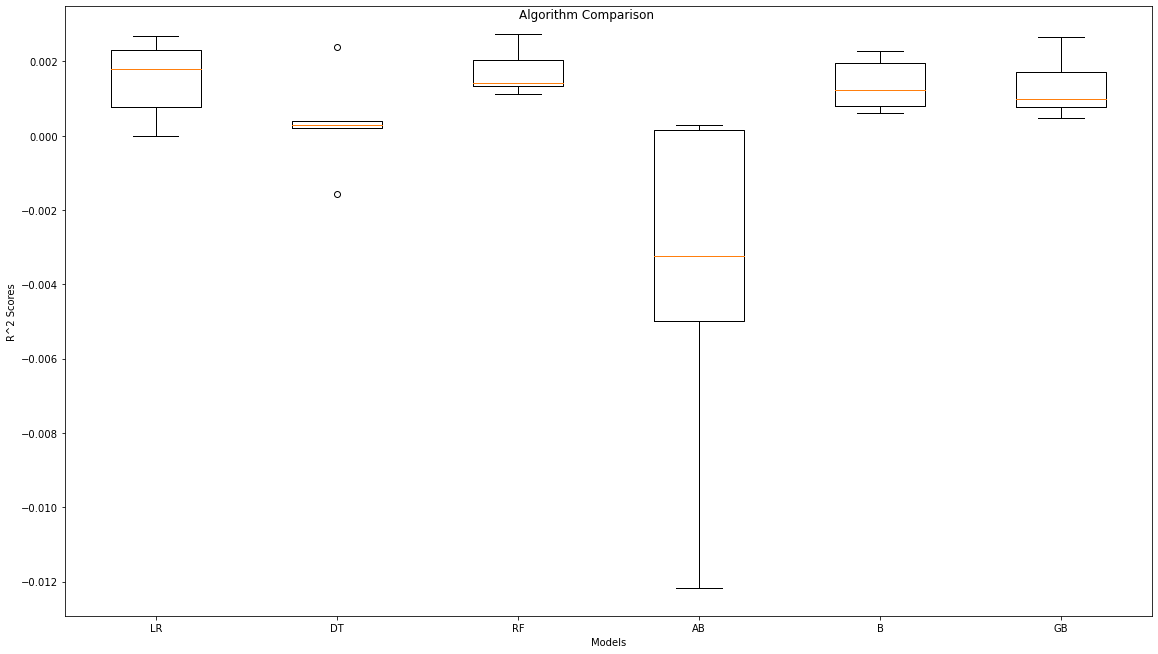

In [59]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(r2_reg_scores.values())
ax.set_xticklabels(r2_reg_scores.keys())


plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('R^2 Scores')
plt.savefig('model_cv_10prct/run4/normalizer/South-Holland-10prct_R2_Except-KNN.png', dpi=600)
plt.show()

In [60]:
mean_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean', add_indicator=True)),
    ('scaler', StandardScaler())])

freq_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', add_indicator=True)),
    ('scaler', StandardScaler())])

zero_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0, add_indicator=True)),
    ('scaler', StandardScaler())])

In [61]:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA', add_indicator=True)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [62]:
preprocessor = ColumnTransformer(transformers=[
        ('mean_transformer', mean_transformer, ["year"]),
        ('freq_transformer', freq_transformer, ["building_levels"]),
        ('zero_transformer', zero_transformer, ["count_neighbor"]),
        ('cat_transfomer', cat_transformer, cat_cols)])

In [63]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

In [64]:
print(sorted(sklearn.metrics.SCORERS.keys()) )

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted', 'v_measure_score']


In [65]:
regressors = []
regressors.append(('LR', LinearRegression()))
regressors.append(('DT', DecisionTreeRegressor(random_state=model_seed)))
# regressors.append(('DT', DecisionTreeRegressor(max_depth=30, random_state=42)))
regressors.append(('KNN', KNeighborsRegressor()))
# regressors.append(('KNN', KNeighborsRegressor(n_neighborsint=30, weights="distance")))
regressors.append(('RF', RandomForestRegressor(random_state=model_seed)))
# regressors.append(('RF', RandomForestRegressor(n_estimators=100, max_depth=10)))
regressors.append(('AB', AdaBoostRegressor(random_state=model_seed)))
regressors.append(('B', BaggingRegressor(random_state=model_seed)))
regressors.append(('GB', GradientBoostingRegressor(random_state=model_seed)))


In [66]:
mae_reg_scores = {}

In [67]:
for name, regressor in regressors:
    cv = ShuffleSplit(n_splits=5, test_size=.2, random_state=cv_seed)
    mdl_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])
    tic = time.process_time()
    scores = cross_val_score(mdl_pipeline, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error', error_score='raise', n_jobs=-1)
    toc = time.process_time()
    elapsed_time = toc - tic
    mae_reg_scores[name] = scores
    msg = "%s: avg: %f (std: %f, max: %f, min: %f) took %f seconds" % (name, scores.mean(), scores.std(), scores.max(), scores.min(), elapsed_time)
    print(msg)

LR: avg: -3.031485 (std: 0.005956, max: -3.024385, min: -3.039964) took 0.593042 seconds
DT: avg: -3.366127 (std: 0.014380, max: -3.345248, min: -3.386617) took 0.584967 seconds
KNN: avg: -2.983651 (std: 0.011653, max: -2.963617, min: -2.995844) took 0.593263 seconds
RF: avg: -3.056298 (std: 0.012620, max: -3.037717, min: -3.077036) took 0.792818 seconds
AB: avg: -3.369347 (std: 0.057882, max: -3.297382, min: -3.433181) took 0.957321 seconds
B: avg: -3.094434 (std: 0.016551, max: -3.074649, min: -3.120500) took 0.564858 seconds
GB: avg: -2.853199 (std: 0.005957, max: -2.842190, min: -2.859401) took 0.551400 seconds


In [68]:
mae_reg_scores

{'LR': array([-3.0399638 , -3.03581234, -3.0243849 , -3.03179936, -3.02546644]),
 'DT': array([-3.34524844, -3.3764855 , -3.36439854, -3.38661657, -3.35788554]),
 'KNN': array([-2.98808467, -2.99584355, -2.96361677, -2.97816011, -2.99254907]),
 'RF': array([-3.05778236, -3.07703629, -3.03771705, -3.05694503, -3.05201164]),
 'AB': array([-3.3089334 , -3.43318127, -3.29738165, -3.43099613, -3.37624208]),
 'B': array([-3.0992795 , -3.07464927, -3.07854102, -3.0992029 , -3.12049973]),
 'GB': array([-2.85662359, -2.8523012 , -2.84218985, -2.85940144, -2.85547881])}

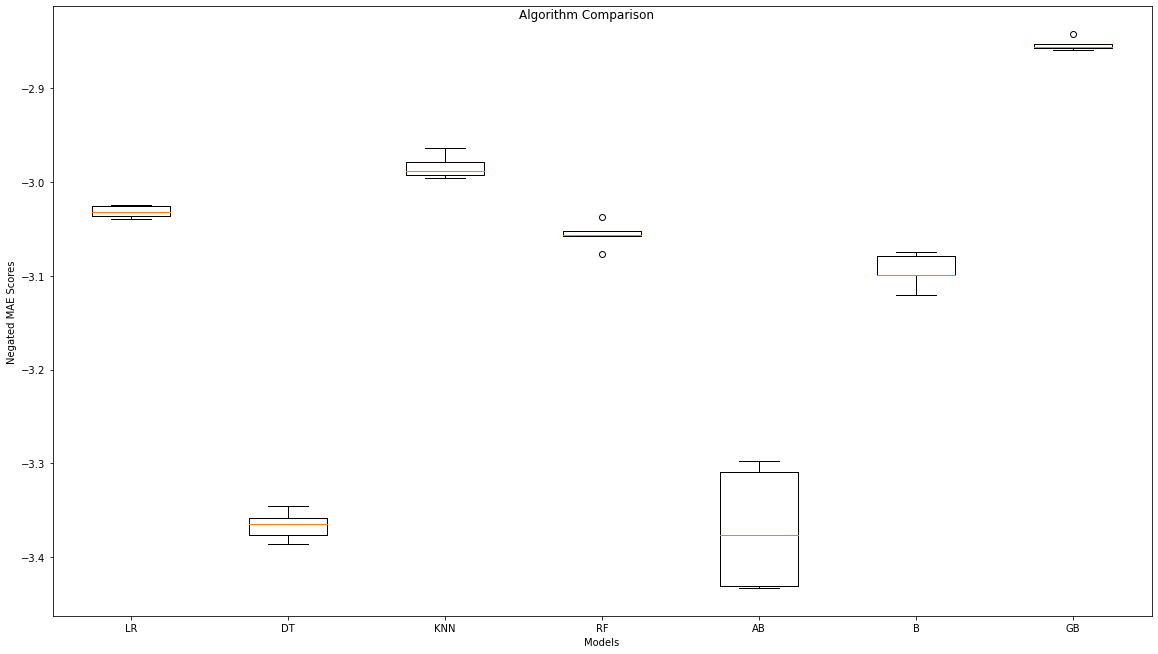

In [69]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot (111)

plt.boxplot(mae_reg_scores.values())
ax.set_xticklabels(mae_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Negated MAE Scores')
plt.savefig('model_cv_10prct/run4/scaler/South-Holland-10prct_MAE.png', dpi=600)

In [70]:
abs_mae_reg_scores = {}
for k, v in mae_reg_scores.items():
    abs_mae_reg_scores[k] = np.absolute(v)

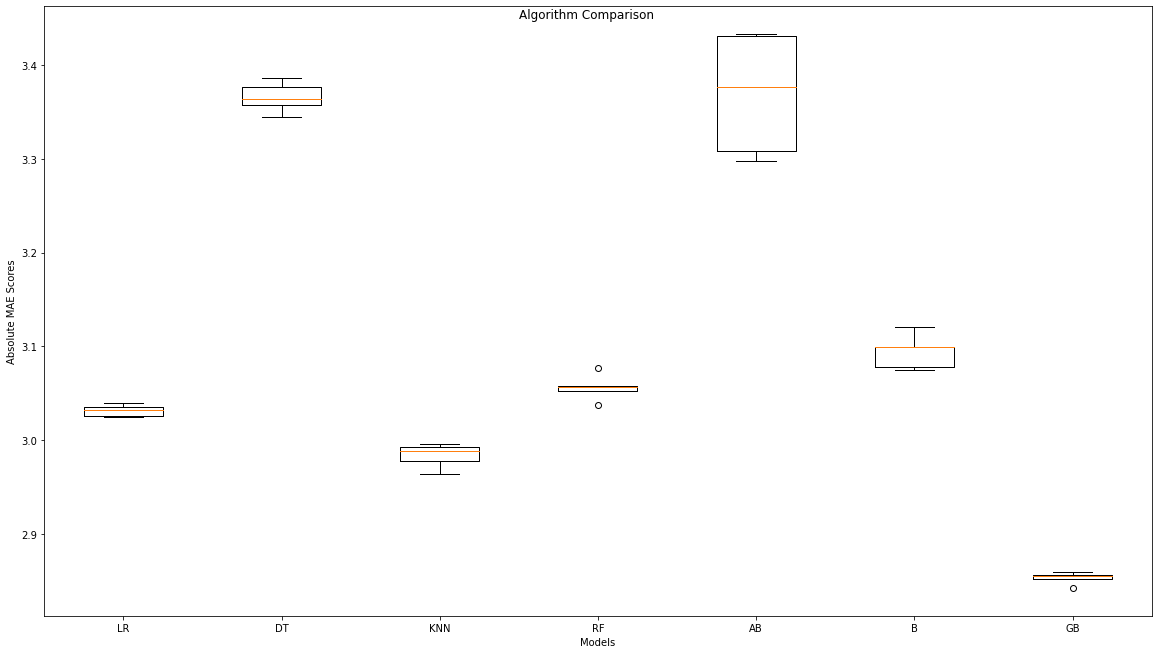

In [71]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot (111)


plt.boxplot(abs_mae_reg_scores.values())
ax.set_xticklabels(abs_mae_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Absolute MAE Scores')
plt.savefig('model_cv_10prct/run4/scaler/South-Holland-10prct_ABS-MAE.png', dpi=600)

In [72]:

if 'AB' in mae_reg_scores.keys():
    del mae_reg_scores['AB'] 
mae_reg_scores

{'LR': array([-3.0399638 , -3.03581234, -3.0243849 , -3.03179936, -3.02546644]),
 'DT': array([-3.34524844, -3.3764855 , -3.36439854, -3.38661657, -3.35788554]),
 'KNN': array([-2.98808467, -2.99584355, -2.96361677, -2.97816011, -2.99254907]),
 'RF': array([-3.05778236, -3.07703629, -3.03771705, -3.05694503, -3.05201164]),
 'B': array([-3.0992795 , -3.07464927, -3.07854102, -3.0992029 , -3.12049973]),
 'GB': array([-2.85662359, -2.8523012 , -2.84218985, -2.85940144, -2.85547881])}

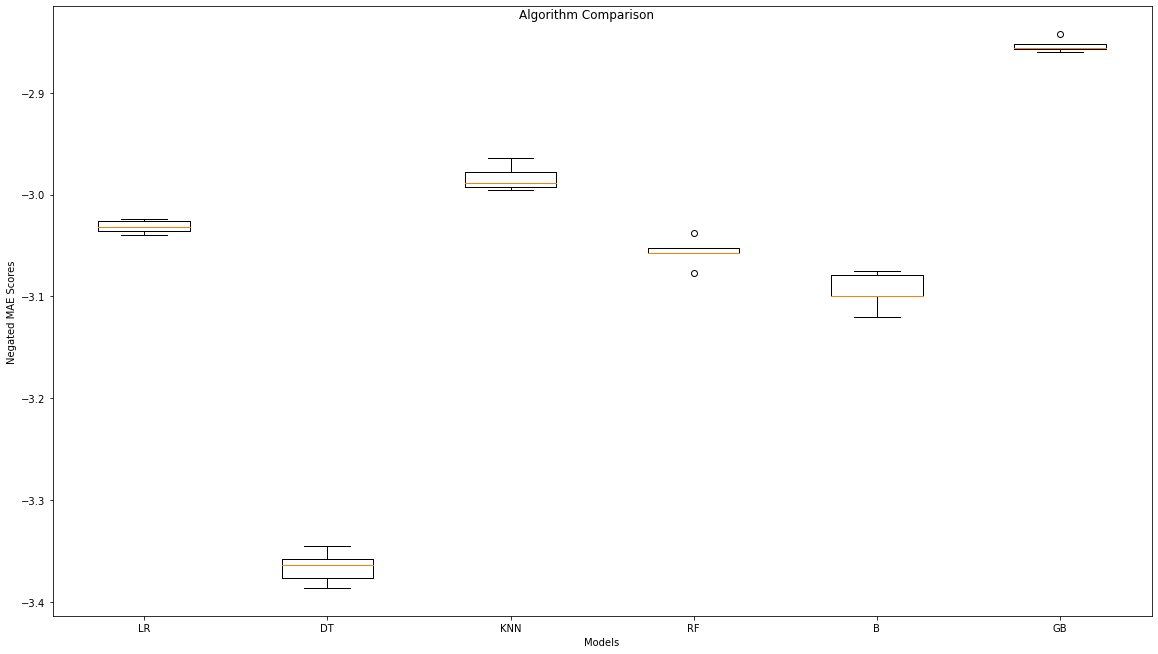

In [73]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(mae_reg_scores.values())
ax.set_xticklabels(mae_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Negated MAE Scores')
plt.savefig('model_cv_10prct/run4/scaler/South-Holland-10prct_MAE_Except-AB.png', dpi=600)


In [74]:
if 'AB' in abs_mae_reg_scores.keys():
    del abs_mae_reg_scores['AB'] 
abs_mae_reg_scores

{'LR': array([3.0399638 , 3.03581234, 3.0243849 , 3.03179936, 3.02546644]),
 'DT': array([3.34524844, 3.3764855 , 3.36439854, 3.38661657, 3.35788554]),
 'KNN': array([2.98808467, 2.99584355, 2.96361677, 2.97816011, 2.99254907]),
 'RF': array([3.05778236, 3.07703629, 3.03771705, 3.05694503, 3.05201164]),
 'B': array([3.0992795 , 3.07464927, 3.07854102, 3.0992029 , 3.12049973]),
 'GB': array([2.85662359, 2.8523012 , 2.84218985, 2.85940144, 2.85547881])}

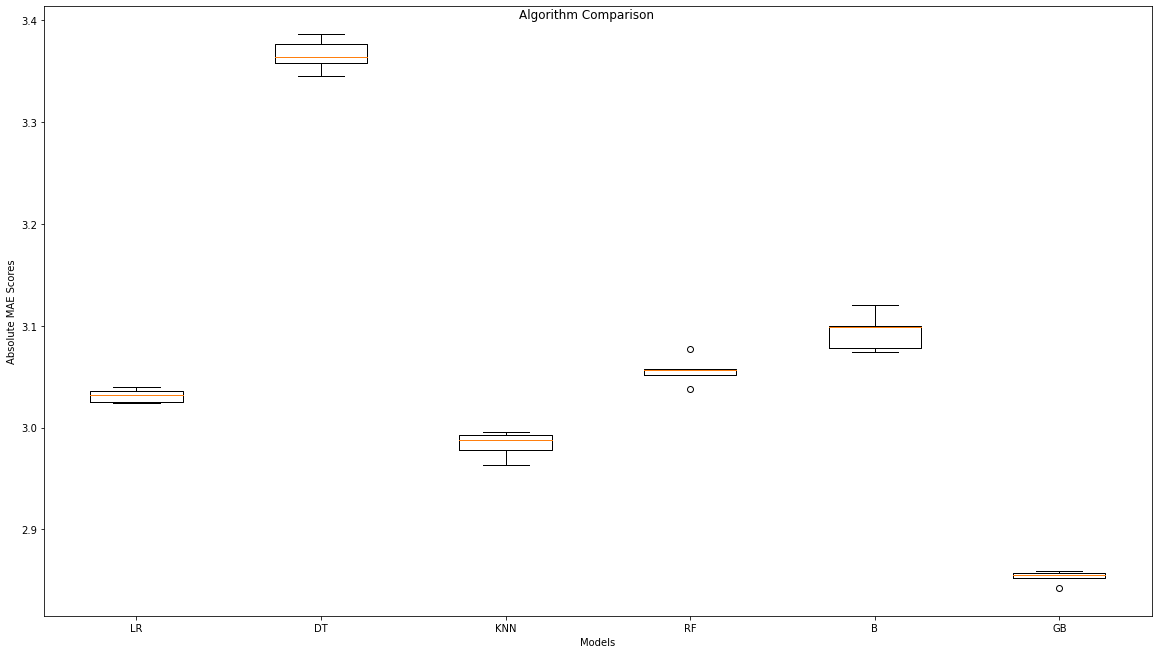

In [75]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(abs_mae_reg_scores.values())
ax.set_xticklabels(abs_mae_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Absolute MAE Scores')
plt.savefig('model_cv_10prct/run4/scaler/South-Holland-10prct_ABS-MAE_Except-AB.png', dpi=600)

In [76]:
mse_reg_scores = {}

In [77]:
for name, regressor in regressors:
    cv = ShuffleSplit(n_splits=5, test_size=.2, random_state=cv_seed)
    mdl_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])
    tic = time.process_time()
    scores = cross_val_score(mdl_pipeline, X_train, y_train, cv=cv, scoring='neg_mean_squared_error', error_score='raise', n_jobs=-1)
    toc = time.process_time()
    elapsed_time = toc - tic
    mse_reg_scores[name] = scores
    msg = "%s: avg: %f (std: %f, max: %f, min: %f) took %f seconds" % (name, scores.mean(), scores.std(), scores.max(), scores.min(), elapsed_time)
    print(msg)

LR: avg: -13.779002 (std: 0.417559, max: -13.241548, min: -14.461377) took 0.573858 seconds
DT: avg: -20.934550 (std: 0.373628, max: -20.347481, min: -21.422209) took 0.592668 seconds
KNN: avg: -14.428968 (std: 0.115085, max: -14.281777, min: -14.569138) took 0.583864 seconds
RF: avg: -15.973886 (std: 0.263704, max: -15.722259, min: -16.437419) took 0.591751 seconds
AB: avg: -20.487051 (std: 5.714504, max: -16.125494, min: -31.676784) took 1.011929 seconds
B: avg: -16.430796 (std: 0.390438, max: -15.961121, min: -17.020103) took 0.554515 seconds
GB: avg: -12.327353 (std: 0.326232, max: -11.735829, min: -12.636728) took 0.561783 seconds


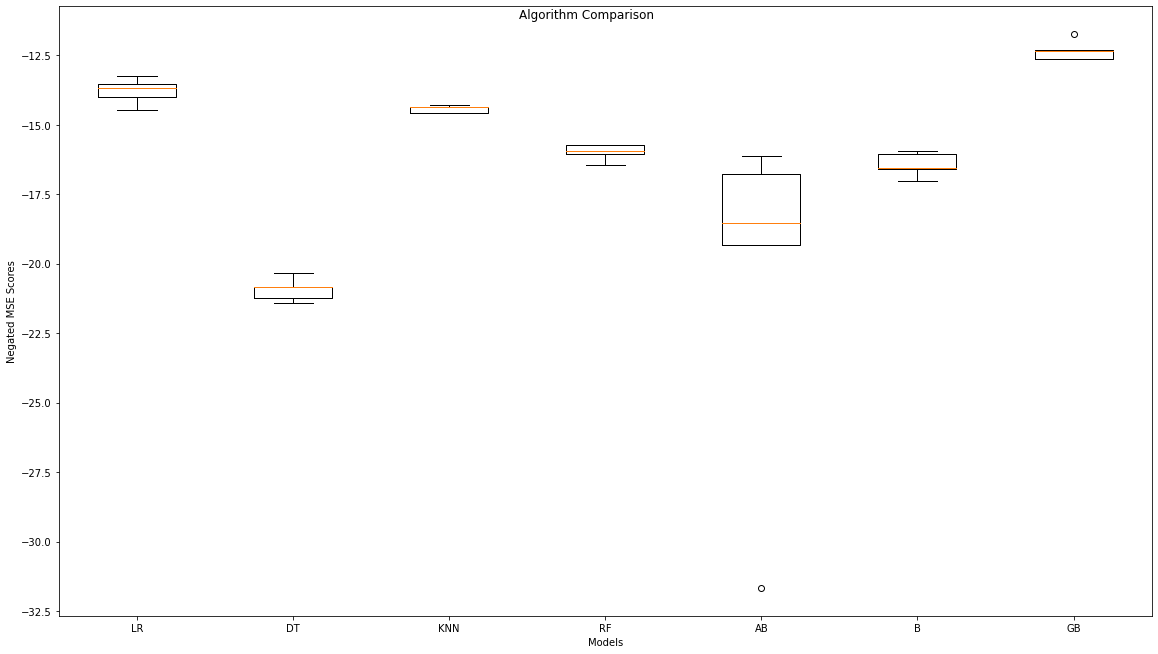

In [78]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(mse_reg_scores.values())
ax.set_xticklabels(mse_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Negated MSE Scores')
plt.savefig('model_cv_10prct/run4/scaler/South-Holland-10prct_MSE.png', dpi=600)
plt.show()

In [79]:
abs_mse_reg_scores = {}
for k, v in mse_reg_scores.items():
    abs_mse_reg_scores[k] = np.absolute(v)
    
abs_mse_reg_scores

{'LR': array([13.24154817, 14.4613772 , 13.98388785, 13.68813445, 13.52006206]),
 'DT': array([21.42220868, 20.8262049 , 20.83568567, 21.24116965, 20.34748055]),
 'KNN': array([14.5601186 , 14.36521639, 14.36859014, 14.56913769, 14.28177653]),
 'RF': array([15.92797131, 15.72713059, 16.43741856, 15.72225935, 16.05465054]),
 'AB': array([18.53334339, 16.12549444, 16.75611787, 31.67678361, 19.34351603]),
 'B': array([16.54190577, 15.9611211 , 17.02010284, 16.59414376, 16.03670869]),
 'GB': array([11.73582937, 12.63672826, 12.34669608, 12.29810921, 12.61940209])}

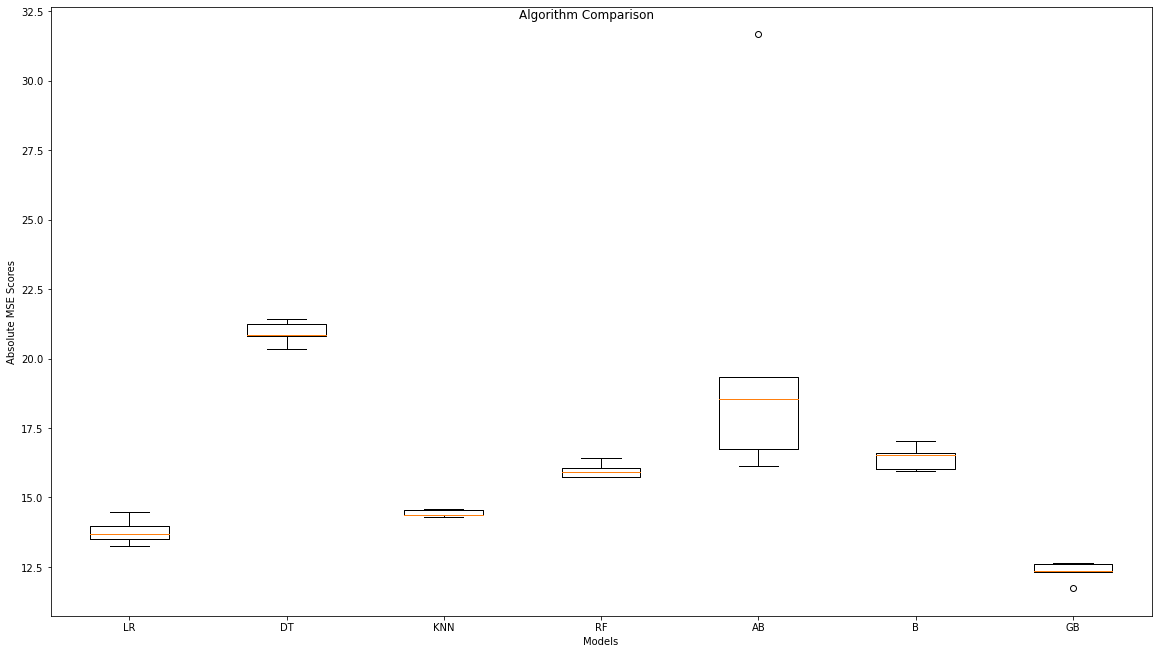

In [80]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot (111)


plt.boxplot(abs_mse_reg_scores.values())
ax.set_xticklabels(abs_mse_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Absolute MSE Scores')
plt.savefig('model_cv_10prct/run4/scaler/South-Holland-10prct_ABS-MSE.png', dpi=600)

In [81]:
if 'AB' in mse_reg_scores.keys():
    del mse_reg_scores['AB'] 
mse_reg_scores

{'LR': array([-13.24154817, -14.4613772 , -13.98388785, -13.68813445,
        -13.52006206]),
 'DT': array([-21.42220868, -20.8262049 , -20.83568567, -21.24116965,
        -20.34748055]),
 'KNN': array([-14.5601186 , -14.36521639, -14.36859014, -14.56913769,
        -14.28177653]),
 'RF': array([-15.92797131, -15.72713059, -16.43741856, -15.72225935,
        -16.05465054]),
 'B': array([-16.54190577, -15.9611211 , -17.02010284, -16.59414376,
        -16.03670869]),
 'GB': array([-11.73582937, -12.63672826, -12.34669608, -12.29810921,
        -12.61940209])}

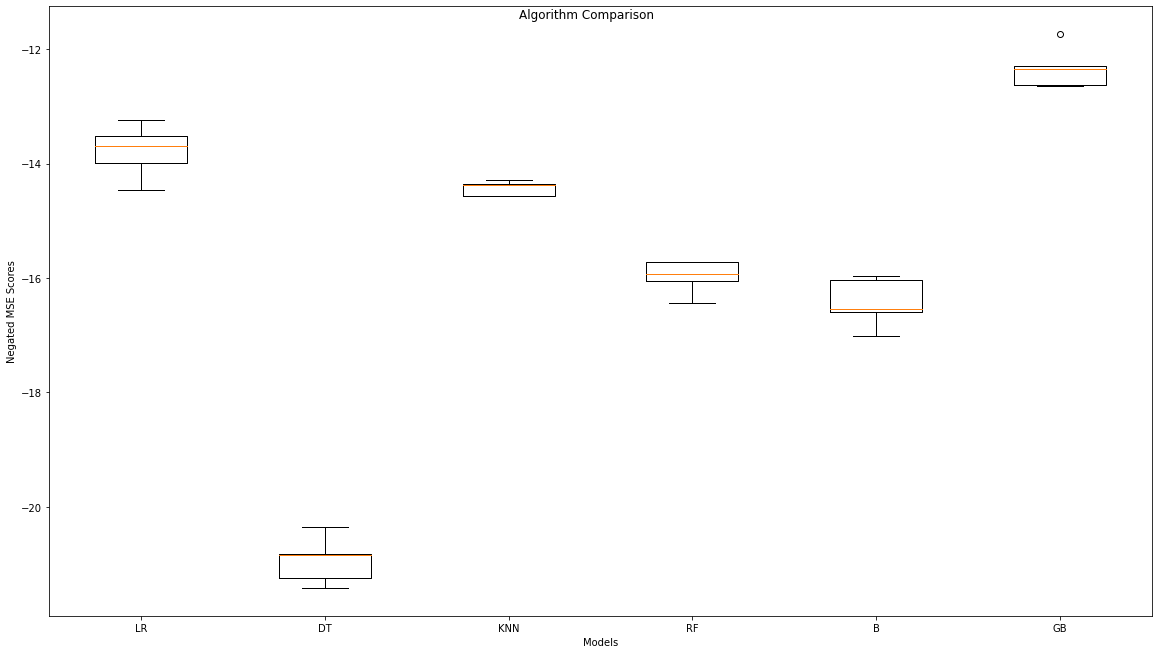

In [82]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(mse_reg_scores.values())
ax.set_xticklabels(mse_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Negated MSE Scores')
plt.savefig('model_cv_10prct/run4/scaler/South-Holland-10prct_MSE_Except-AB.png', dpi=600)
plt.show()

In [83]:
if 'AB' in abs_mse_reg_scores.keys():
    del abs_mse_reg_scores['AB'] 
abs_mse_reg_scores

{'LR': array([13.24154817, 14.4613772 , 13.98388785, 13.68813445, 13.52006206]),
 'DT': array([21.42220868, 20.8262049 , 20.83568567, 21.24116965, 20.34748055]),
 'KNN': array([14.5601186 , 14.36521639, 14.36859014, 14.56913769, 14.28177653]),
 'RF': array([15.92797131, 15.72713059, 16.43741856, 15.72225935, 16.05465054]),
 'B': array([16.54190577, 15.9611211 , 17.02010284, 16.59414376, 16.03670869]),
 'GB': array([11.73582937, 12.63672826, 12.34669608, 12.29810921, 12.61940209])}

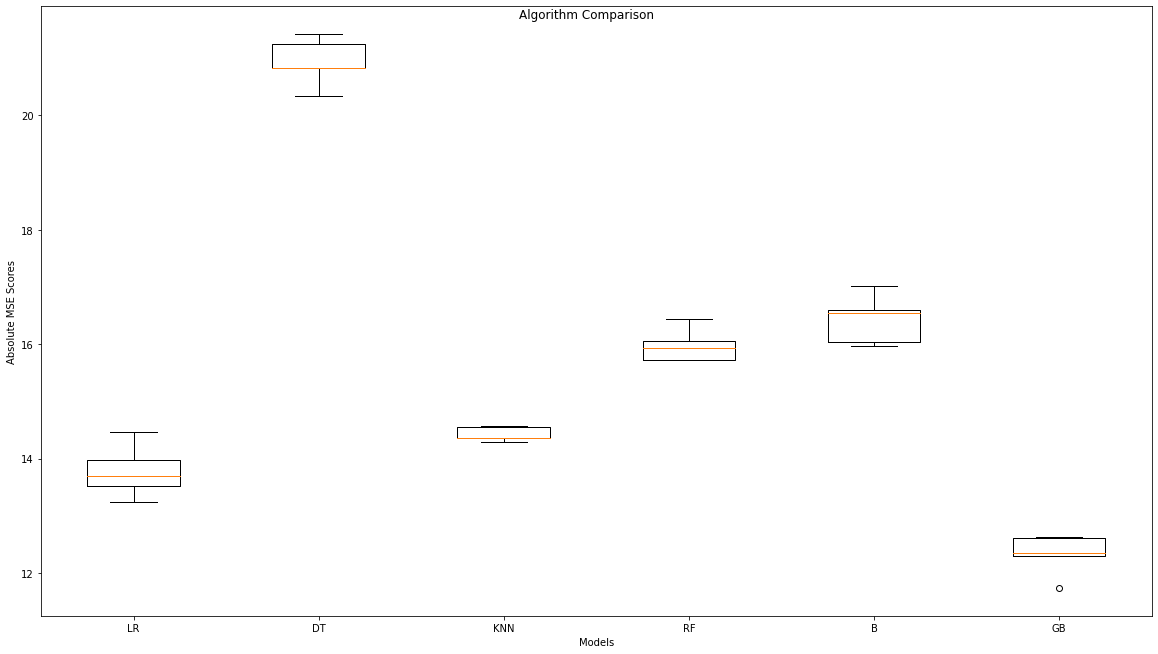

In [84]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(abs_mse_reg_scores.values())
ax.set_xticklabels(abs_mse_reg_scores.keys())

plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('Absolute MSE Scores')
plt.savefig('model_cv_10prct/run4/scaler/South-Holland-10prct_ABS-MSE_Except-AB.png', dpi=600)
plt.show()

In [85]:
r2_reg_scores = {}

In [86]:
for name, regressor in regressors:
    cv = ShuffleSplit(n_splits=5, test_size=.2, random_state=cv_seed)
    mdl_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])
    tic = time.process_time()
    scores = cross_val_score(mdl_pipeline, X_train, y_train, cv=cv, scoring='r2', error_score='raise', n_jobs=-1)
    toc = time.process_time()
    elapsed_time = toc - tic
    r2_reg_scores[name] = scores
    msg = "%s: avg: %f (std: %f, max: %f, min: %f) took %f seconds" % (name, scores.mean(), scores.std(), scores.max(), scores.min(), elapsed_time)
    print(msg)

LR: avg: 0.051706 (std: 0.004976, max: 0.057922, min: 0.045757) took 0.546407 seconds
DT: avg: -0.505760 (std: 0.032066, max: -0.469396, min: -0.558742) took 0.573027 seconds
KNN: avg: -0.018556 (std: 0.004832, max: -0.012114, min: -0.025104) took 0.576942 seconds
RF: avg: -0.121517 (std: 0.015280, max: -0.107751, min: -0.150933) took 0.600440 seconds
AB: avg: -0.365059 (std: 0.389099, max: -0.034328, min: -1.121434) took 1.065738 seconds
B: avg: -0.165212 (std: 0.025052, max: -0.141334, min: -0.212787) took 0.561550 seconds
GB: avg: 0.129466 (std: 0.005414, max: 0.137620, min: 0.123415) took 0.558836 seconds


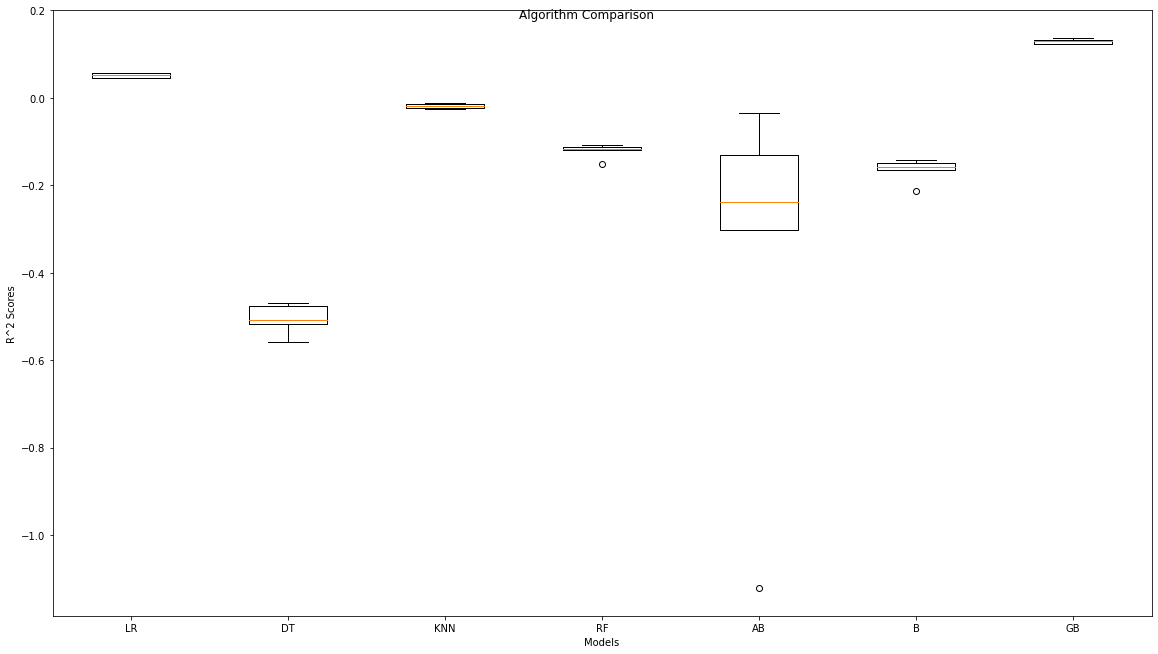

In [87]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(r2_reg_scores.values())
ax.set_xticklabels(r2_reg_scores.keys())


plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('R^2 Scores')
plt.savefig('model_cv_10prct/run4/scaler/South-Holland-10prct_R2.png', dpi=600)
plt.show()

In [88]:
if 'AB' in r2_reg_scores.keys():
    del r2_reg_scores['AB']
r2_reg_scores

{'LR': array([0.05792184, 0.05293112, 0.04575746, 0.05581609, 0.0461024 ]),
 'DT': array([-0.4693955 , -0.47624451, -0.51756728, -0.55874202, -0.50685155]),
 'KNN': array([-0.01901383, -0.01211403, -0.02510439, -0.01427601, -0.02227296]),
 'RF': array([-0.11965855, -0.10775134, -0.11197873, -0.11726469, -0.15093346]),
 'B': array([-0.21278714, -0.14967496, -0.15727186, -0.141334  , -0.16499106]),
 'GB': array([0.12341484, 0.13761971, 0.13298484, 0.1294195 , 0.12388942])}

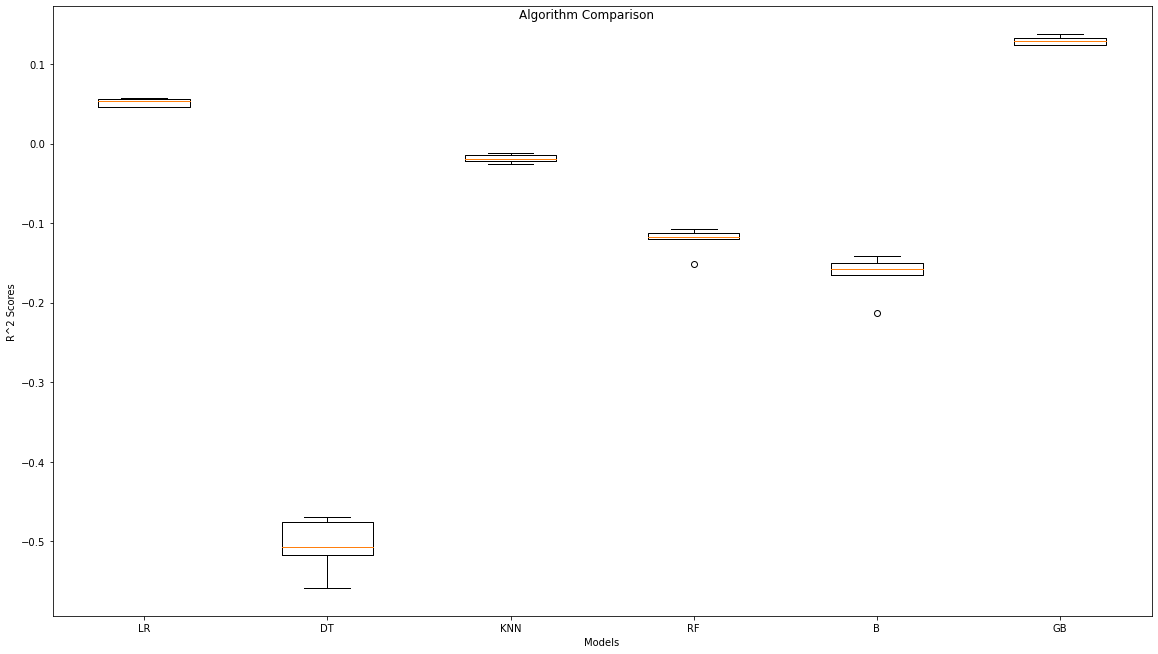

In [89]:
fig = plt.figure(figsize=(16,9))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)

plt.boxplot(r2_reg_scores.values())
ax.set_xticklabels(r2_reg_scores.keys())


plt.tight_layout()
plt.plot()
plt.xlabel('Models')
plt.ylabel('R^2 Scores')
plt.savefig('model_cv_10prct/run4/scaler/South-Holland-10prct_R2_Except-AB.png', dpi=600)
plt.show()